<a id='top'></a>
<div class="list-group" id="list-tab" role="tablist">
<p style="background-color:#4A1810;font-family:sans-serif;color:#FFFFFF;font-size:350%;text-align:center;border-radius:55px 1px;">Pneumonia detection 🩻🩻 </p>

<a id='top'></a>
<div class="list-group" id="list-tab" role="tablist">
<p style="background-color:#4A1810; font-family:sans-serif;color:#FFFFFF;font-size:150%;text-align:center;border-radius:55px 1px;"> Introduction </p>

<div style="border:px solid blue; border-radius:1px; padding:px">
    <img src="https://news.mit.edu/sites/default/files/styles/news_article__image_gallery/public/images/202206/MIT-Pneumonia-Sensor-01-press_0.jpg?itok=pY607Gyu" width="100%">
</div>

<p style="font-size:15px;color:#000000;font-weight:500;"> What is the pneumonia? </p>

Pneumonia is an infection that inflames the air sacs in one or both lungs. The air sacs may fill with fluid or pus, causing cough with phlegm or pus, fever, chills, and difficulty breathing. A variety of organisms, including bacteria, viruses and fungi, can cause pneumonia

<p style="font-size:15px;color:#000000;font-weight:500;"> What is the main cause of pneumonia? </p>

Viruses that infect your lungs and airways can cause pneumonia. The flu (influenza virus) and the common cold (rhinovirus) are the most common causes of viral pneumonia in adults. Respiratory syncytial virus is the most common cause of viral pneumonia in young children

<p style="font-size:15px;color:#000000;font-weight:500;"> For more and detailed information: </p>

https://en.wikipedia.org/wiki/Pneumonia

<a id='top'></a>
<div class="list-group" id="list-tab" role="tablist">
<p style="background-color:#4A1810; font-family:sans-serif;color:#FFFFFF;font-size:130%;text-align:center;border-radius:55px 1px;">Import necessary libraries</p>

In [1]:
#!pip install -U git+https://github.com/albumentations-team/albumentations
#!pip install np_utils

In [2]:
%%time

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import cv2, os, random
import plotly
import plotly.graph_objs as go
import plotly.express as px
from plotly.offline import init_notebook_mode, plot, iplot

#____________________________________________________________

import glob
import tensorflow
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from mlxtend.plotting import plot_confusion_matrix
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications.vgg16 import VGG16
from sklearn.model_selection import train_test_split

#____________________________________________________________

from tqdm.notebook import tqdm
from termcolor import colored
import albumentations as A

#____________________________________________________________

from warnings import filterwarnings
filterwarnings("ignore")

from sklearn import set_config
set_config(print_changed_only = False)
directory = "../input/chest-xray-pneumonia/chest_xray/"

#____________________________________________________________

print(colored("Required libraries were succesfully imported...", color = "green", attrs = ["bold", "dark"]))

Required libraries were succesfully imported...
CPU times: user 3.49 s, sys: 872 ms, total: 4.36 s
Wall time: 8.67 s


### Check GPU

In [3]:
print(tensorflow.config.list_physical_devices("GPU"))

print("________________________________________________")

print(tensorflow.test.is_gpu_available(cuda_only = False, min_cuda_compute_capability = None))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
________________________________________________


2022-12-16 18:03:19.952841: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-16 18:03:19.956880: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-16 18:03:19.957591: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-16 18:03:19.961608: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

True


In [4]:
print("Current tensorflow version == {}".format(tensorflow. __version__))

Current tensorflow version == 2.6.4


<a id='top'></a>
<div class="list-group" id="list-tab" role="tablist">
<p style="background-color:#4A1810; font-family:sans-serif;color:#FFFFFF;font-size:130%;text-align:center;border-radius:55px 1px;">Load the datasets 🔺️</p>

In [5]:
%%time

train_df = glob.glob("../input/chest-xray-pneumonia/chest_xray/train/**/*.jpeg")
test_df = glob.glob("../input/chest-xray-pneumonia/chest_xray/test/**/*.jpeg")
validation_df = glob.glob("../input/chest-xray-pneumonia/chest_xray/val/**/*.jpeg")

print(colored("The datasets were succesfully loaded...", color = "green", attrs = ["bold", "dark"]))

The datasets were succesfully loaded...
CPU times: user 14.7 ms, sys: 9.76 ms, total: 24.4 ms
Wall time: 269 ms


#### <span style='background:#4A1810;color:#ffffff;'> Look at train and test sets </span>

In [6]:
train_df[:5], test_df[:5]

(['../input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person1180_virus_2010.jpeg',
  '../input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person1230_virus_2081.jpeg',
  '../input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person1513_virus_2632.jpeg',
  '../input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person124_virus_238.jpeg',
  '../input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person746_virus_1369.jpeg'],
 ['../input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA/person1676_virus_2892.jpeg',
  '../input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA/person1650_virus_2852.jpeg',
  '../input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA/person22_virus_55.jpeg',
  '../input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA/person122_bacteria_582.jpeg',
  '../input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA/person85_bacteria_417.jpeg'])

<a id='top'></a>
<div class="list-group" id="list-tab" role="tablist">
<p style="background-color:#4A1810; font-family:sans-serif;color:#FFFFFF;font-size:130%;text-align:center;border-radius:55px 1px;">Do some data exploration 🔺️</p>

#### <span style='background:#4A1810;color:#ffffff;'> How many images are in each dataset? </span>

In [7]:
print("There is {} images in the training dataset".format(len(train_df)))
print("There is {} images in the test dataset".format(len(test_df)))
print("There is {} images in the validation dataset".format(len(validation_df)))

There is 5216 images in the training dataset
There is 624 images in the test dataset
There is 16 images in the validation dataset


#### <span style='background:#4A1810;color:#ffffff;'> How many of the pictures are of pneumonic lungs and how many are of normal lungs </span>

In [8]:
datasets, pneumonia_lung, normal_lung = ["train", "test", "val"], [], []

for i in datasets:
    path = os.path.join(directory, i)
    normal = glob.glob(os.path.join(path, "NORMAL/*.jpeg"))
    pneumonia = glob.glob(os.path.join(path, "PNEUMONIA/*.jpeg"))
    normal_lung.extend(normal), pneumonia_lung.extend(pneumonia)

print("The number of pneumonia images is {}".format(len(pneumonia_lung)))
print("The number of non-pneumonia images is {}".format(len(normal_lung)))

The number of pneumonia images is 4273
The number of non-pneumonia images is 1583


#### <span style='background:#4A1810;color:#ffffff;'> Shuffle the images </span>

In [9]:
random.shuffle(normal_lung)
random.shuffle(pneumonia_lung)
images = normal_lung[:50] + pneumonia_lung[:50]
images[:10]

['../input/chest-xray-pneumonia/chest_xray/test/NORMAL/IM-0079-0001.jpeg',
 '../input/chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0379-0001.jpeg',
 '../input/chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0673-0001.jpeg',
 '../input/chest-xray-pneumonia/chest_xray/train/NORMAL/NORMAL2-IM-0839-0001.jpeg',
 '../input/chest-xray-pneumonia/chest_xray/train/NORMAL/NORMAL2-IM-1162-0001.jpeg',
 '../input/chest-xray-pneumonia/chest_xray/train/NORMAL/NORMAL2-IM-0843-0001.jpeg',
 '../input/chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0242-0001.jpeg',
 '../input/chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0355-0001.jpeg',
 '../input/chest-xray-pneumonia/chest_xray/train/NORMAL/NORMAL2-IM-1285-0001.jpeg',
 '../input/chest-xray-pneumonia/chest_xray/train/NORMAL/NORMAL2-IM-1385-0001.jpeg']

#### <span style='background:#4A1810;color:#ffffff;'> View the images in X-ray format </span>

<mark>X-ray imaging creates pictures of the inside of a body. The images show the parts of a body in different shades of black and white. This is because different tissues absorb different amounts of radiation. Calcium in bones absorbs x-rays the most, so bones look white</mark>

NORMAL


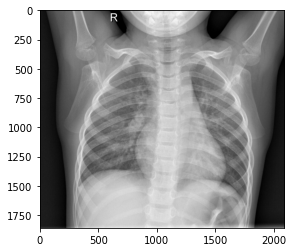

In [10]:
normal_lung_image = load_img("/kaggle/input/chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0115-0001.jpeg")
print("NORMAL")
plt.imshow(normal_lung_image)
plt.show()

PNEUMONIA


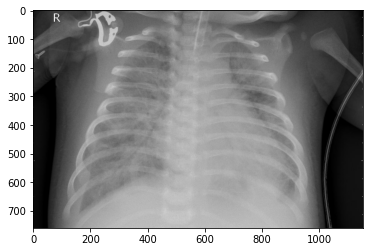

In [11]:
normal_lung_image = load_img("/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person1000_bacteria_2931.jpeg")
print("PNEUMONIA")
plt.imshow(normal_lung_image)
plt.show()

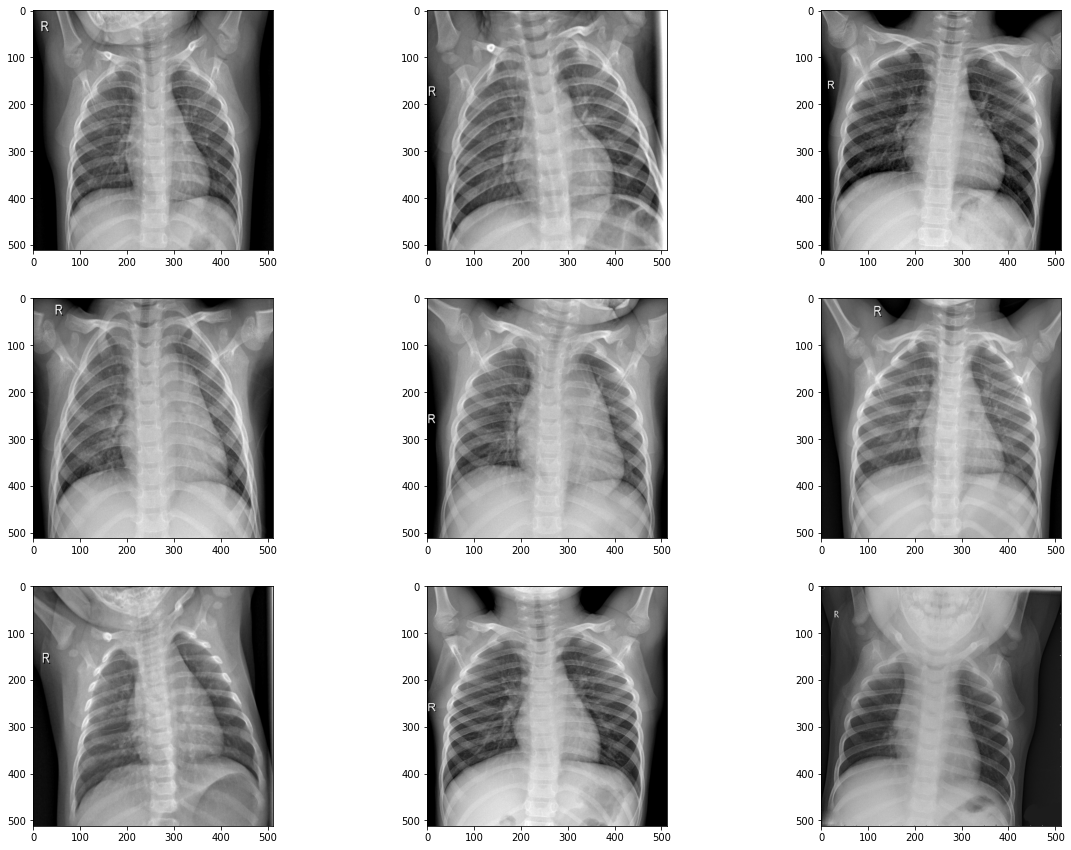

In [12]:
fig = plt.figure(figsize = (20, 15))
columns, rows = 3, 3
for i in range(1, 10):
    img = cv2.imread(images[i])
    img = cv2.resize(img, (512, 512))
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)

#### <span style='background:#4A1810;color:#ffffff;'> Image erosion </span>

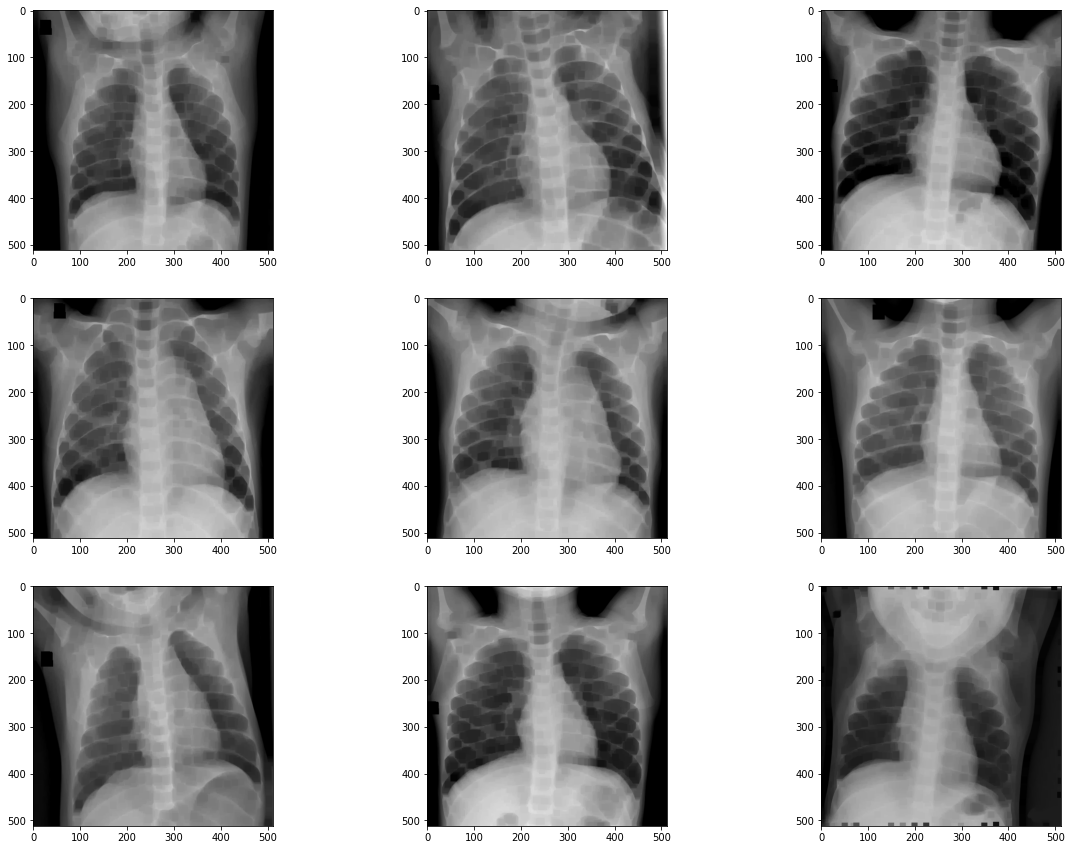

In [13]:
fig = plt.figure(figsize = (20, 15))
columns, rows = 3, 3
for i in range(1, 10):
    img = cv2.imread(images[i])
    img = cv2.resize(img, (512, 512))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    kernel = np.ones((5, 5), np.uint8)
    image_erosion = cv2.erode(img, kernel, iterations=3)
    fig.add_subplot(rows, columns, i)
    plt.imshow(image_erosion)

#### <span style='background:#4A1810;color:#ffffff;'> Image dilation </span>

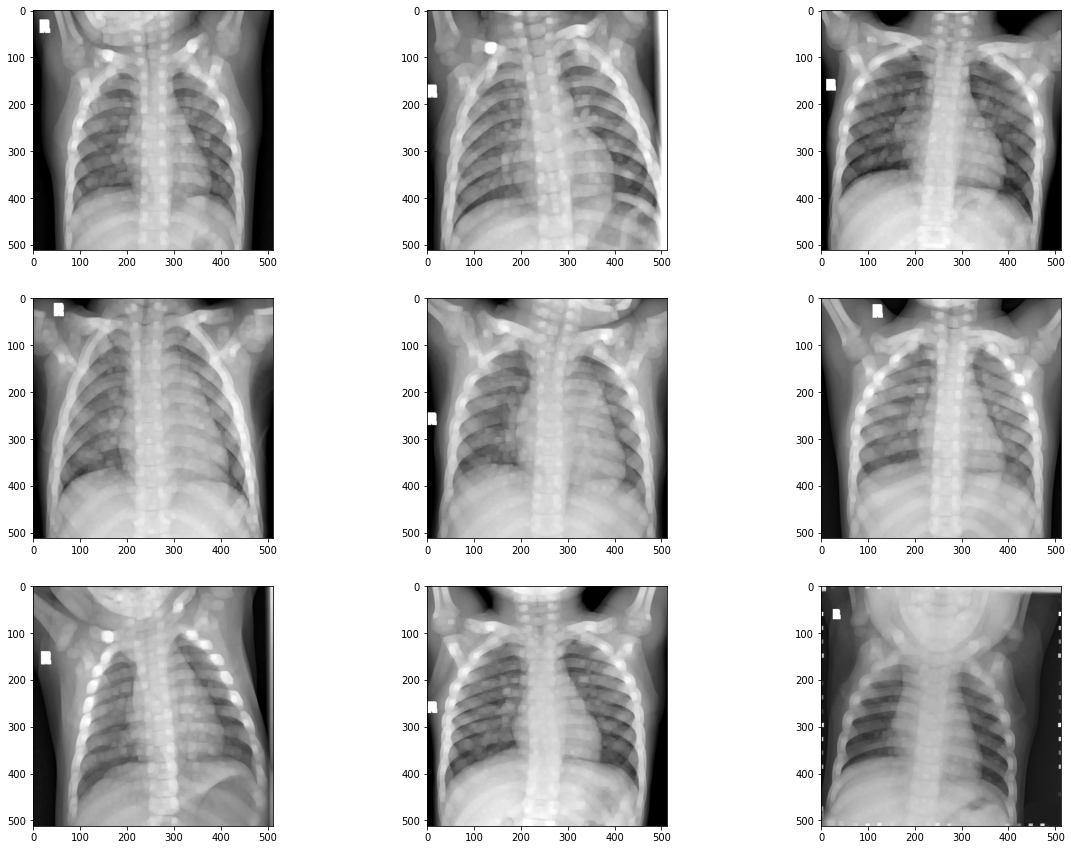

In [14]:
fig = plt.figure(figsize = (20, 15))
columns, rows = 3, 3

for i in range(1, 10):
    img = cv2.imread(images[i])
    img = cv2.resize(img, (512, 512))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    kernel = np.ones((5, 5), np.uint8)
    image_dilation = cv2.dilate(img, kernel, iterations = 2)
    fig.add_subplot(rows, columns, i)
    plt.imshow(image_dilation)

#### <span style='background:#4A1810;color:#ffffff;'> Convert the images to greyscale and then apply Gaussian blur to them </span>

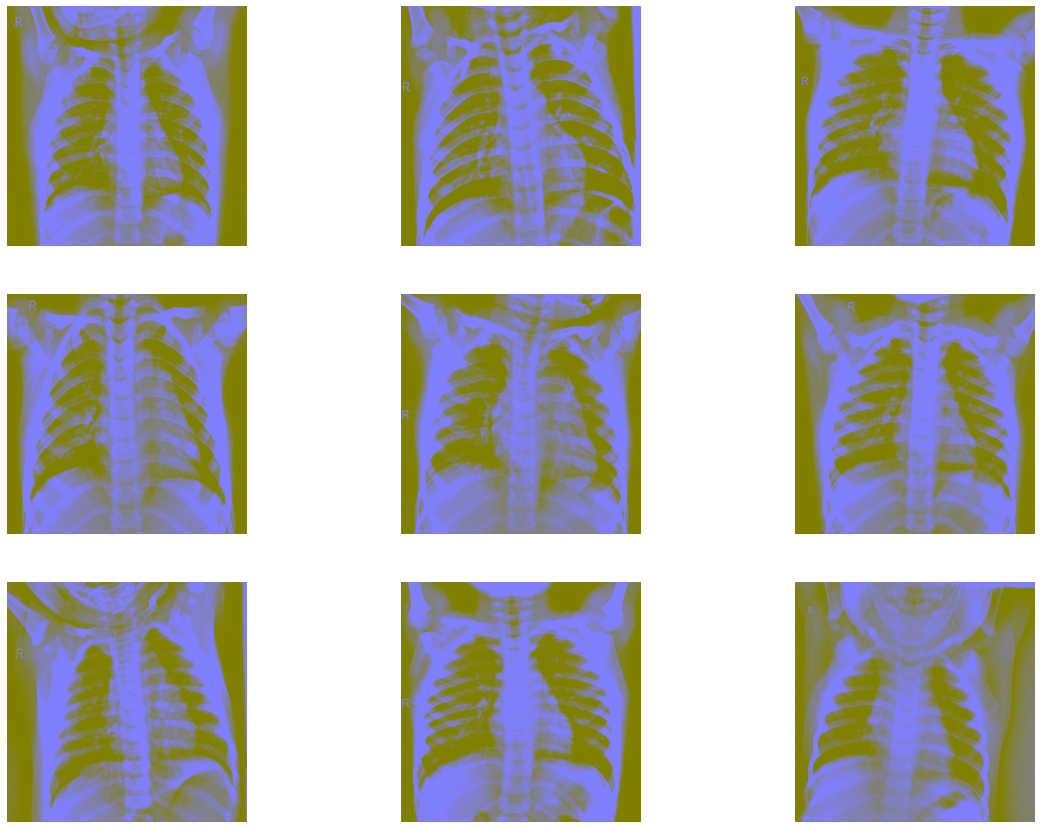

In [15]:
fig = plt.figure(figsize = (20, 15))
columns, rows = 3, 3

for i in range(1, 10):
    img = cv2.imread(images[i])
    img = cv2.resize(img, (512, 512))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    img = cv2.addWeighted (img, 4, cv2.GaussianBlur(img, (0, 0), 512/10), -4, 128)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.axis(False)

#### <span style='background:#4A1810;color:#ffffff;'> Canny edge detection: </span>

<mark>Canny edge detection is a technique to extract useful structural information from different vision objects and dramatically reduce the amount of data to be processed. It has been widely applied in various computer vision systems</mark>

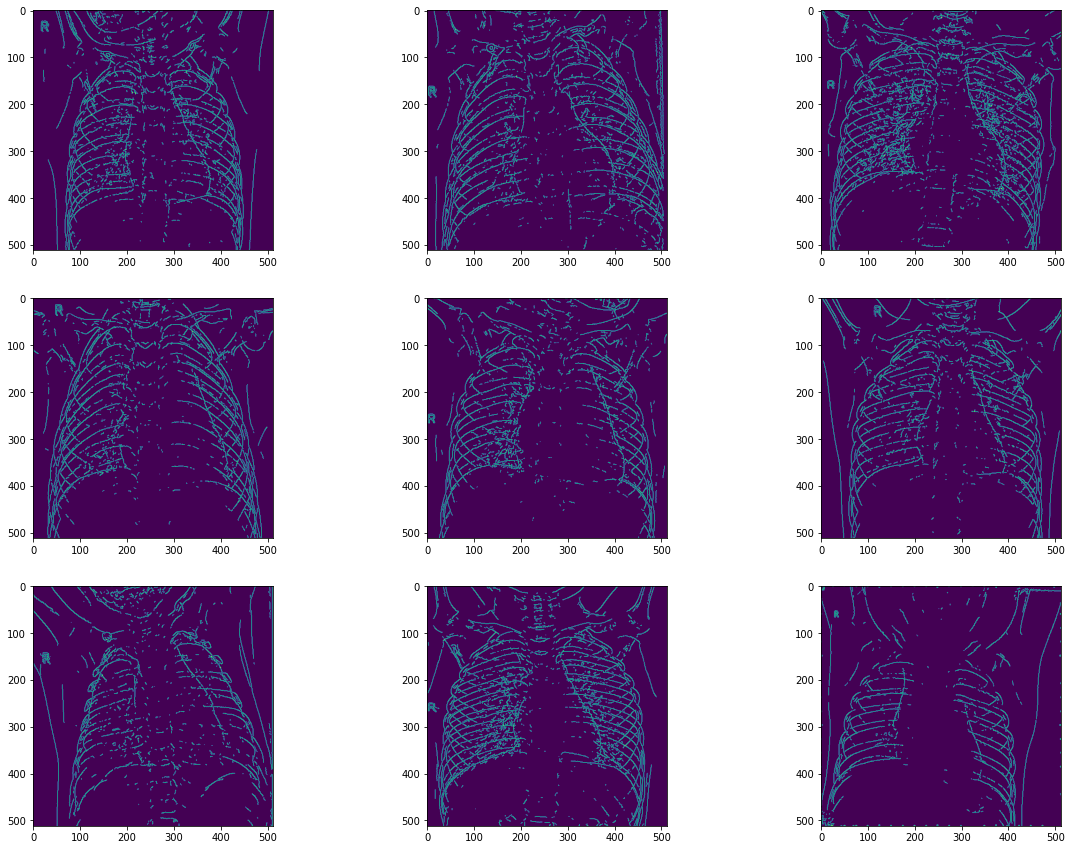

In [16]:
fig = plt.figure(figsize = (20, 15))
columns, rows = 3, 3

for i in range(1, 10):
    img = cv2.imread(images[i])
    img = cv2.resize(img, (512, 512))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    detected_edges = cv2.Canny(img, 80, 100)
    fig.add_subplot(rows, columns, i)
    plt.imshow(detected_edges)

<a id='top'></a>
<div class="list-group" id="list-tab" role="tablist">
<p style="background-color:#4A1810; font-family:sans-serif;color:#FFFFFF;font-size:130%;text-align:center;border-radius:55px 1px;">Build deep learning models 🔺️</p>

In [17]:
train_dir = "../input/chest-xray-pneumonia/chest_xray/train"
test_dir = "../input/chest-xray-pneumonia/chest_xray/test"
validation_dir = "../input/chest-xray-pneumonia/chest_xray/val"

In [18]:
%%time

train_datagen = ImageDataGenerator(
            rescale = 1/255.,
            horizontal_flip = True,
            vertical_flip = True,
            rotation_range = 0.3,
            zca_whitening = True,
            width_shift_range = 0.25,
            height_shift_range = 0.25,
            channel_shift_range = 0.35,
            shear_range = 0.2,
            zoom_range = 0.4)

val_test_datagen = ImageDataGenerator(rescale = 1./255)

train_set = train_datagen.flow_from_directory(train_dir, class_mode = "binary", batch_size = 16, target_size = (224, 224))
validation_set = val_test_datagen.flow_from_directory(validation_dir, class_mode = "binary", batch_size = 16, target_size = (224, 224))
test_set = val_test_datagen.flow_from_directory(test_dir, class_mode = "binary", batch_size = 16, target_size = (224, 224))

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
CPU times: user 193 ms, sys: 114 ms, total: 307 ms
Wall time: 2.38 s


#### <span style='background:#4A1810;color:#ffffff;'> Cache and prefetch data </span>


If we use <mark>flow_from_directory along with ImageDataGenerator()</mark> to set up the dataset, it will not be compatible with <mark>tensorflow.data.AUTOTUNE.</mark> Use <mark>tensorflow.keras.preprocessing.image_dataset_from_directory</mark> instead to load the dataset.

In [19]:
'''
AUTOTUNE = tensorflow.data.experimental.AUTOTUNE

train_set = train_set.cache().prefetch(buffer_size = AUTOTUNE)
test_set = test_set.cache().prefetch(buffer_size = AUTOTUNE)
validation_set = validation_set.cache().prefetch(buffer_size = AUTOTUNE)
'''
pass

#### <span style='background:#4A1810;color:#ffffff;'> Build CNN model 🔺️ </span>

## What is a convolutional neural network algorithm?

A convolutional neural network (ConvNet / Convolutional neural networks -CNN) is a deep learning algorithm that can take an input image and separate various aspects/objects in the image. CNN is a network architecture for deep learning that learns directly from data. CNNs are particularly useful for finding patterns in images to recognize objects, classes, and categories. They can also be quite effective for classifying audio, time-series and signal data.

![](https://miro.medium.com/max/1400/1*uAeANQIOQPqWZnnuH-VEyw.jpeg)


## Convolution layer

A convolutional layer is the main building block of a CNN. It contains a set of filters (or kernels) whose parameters will be learned throughout the training. The size of the filters is usually smaller than the actual image. Each filter intertwines with the image and creates an activation map.

![](https://miro.medium.com/max/1400/1*D6iRfzDkz-sEzyjYoVZ73w.gif)


## Convolutional stride

Stride is a parameter of the neural network's filter that modifies the amount of movement over the image or video.

![](https://csdl-images.ieeecomputer.org/trans/si/2020/04/figures/ko1ab-2961602.gif)


## Convolutional padding

Padding is a term relevant to convolutional neural networks as it refers to the amount of pixels added to an image when it is being processed by the kernel of a CNN. For example, if the padding in a CNN is set to zero, then every pixel value that is added will be of value zero.

What does padding ='same' means? In this case, we add 'p' padding layers such that the output image has the same dimensions as the input image. It is called "same" because the output size is the same as the input size (when stride = 1). Using 'same' ensures that the filter is applied to all the elements of the input. Normally, padding is set to "SAME" while training the model.

![](https://miro.medium.com/max/2000/1*WpOcRWlofm0Z0EDUTKefzg.gif)


## Pooling layer

The purpose of the pooling layers is to reduce the dimensions of the hidden layer by combining the outputs of neuron clusters at the previous layer into a single neuron in the next layer.

![](https://nico-curti.github.io/NumPyNet/NumPyNet/images/maxpool.gif)

![](https://miro.medium.com/max/1400/1*fXxDBsJ96FKEtMOa9vNgjA.gif)

In [20]:
model1 = Sequential()

#convolutional neural networks - CNNs
model1.add(Conv2D(32, (3,3), strides = (1, 1),activation = "relu", padding = "same", input_shape = (224, 224, 3)))
model1.add(MaxPooling2D(pool_size = (2, 2)))
model1.add(Conv2D(64, (3,3), strides = (1, 1), padding = "same", activation = "relu"))
model1.add(MaxPooling2D(pool_size = (2, 2)))
model1.add(Dropout(0.2))
model1.add(Conv2D(128, (3,3), strides = (1, 1), padding = "same", activation = "relu"))
model1.add(MaxPooling2D(pool_size = (2, 2)))
model1.add(Conv2D(256, (3,3), strides = (1, 1), padding = "same", activation = "relu"))
model1.add(MaxPooling2D(pool_size = (2, 2)))
model1.add(Dropout(0.2))
model1.add(Flatten())

#fully connected layer
model1.add(Dense(128, activation = "relu"))
model1.add(Dense(64, activation = "relu"))
model1.add(Dense(32, activation = "relu"))
model1.add(Dense(1, activation = "sigmoid"))
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 128)       0

2022-12-16 18:03:41.555930: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-16 18:03:41.556776: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-16 18:03:41.557403: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-16 18:03:41.558071: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-16 18:03:41.558677: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

#### <span style='background:#4A1810;color:#ffffff;'> Compile the model </span>

In [21]:
model1.compile(optimizer = "rmsprop", loss = "binary_crossentropy", metrics = ["accuracy"])

#### <span style='background:#4A1810;color:#ffffff;'> Train the model </span>

In [22]:
%%time

early_stopping_callbacks = tensorflow.keras.callbacks.EarlyStopping(patience = 15,
                                                                    restore_best_weights = True,
                                                                    verbose = 1)

CPU times: user 24 µs, sys: 2 µs, total: 26 µs
Wall time: 30.3 µs


In [23]:
%%time

history = model1.fit_generator(train_set, epochs = 20,
                              validation_data = validation_set,
                              steps_per_epoch = 100,
                              callbacks = [early_stopping_callbacks])

2022-12-16 18:03:43.252754: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20


2022-12-16 18:03:45.468728: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


100/100 [==============================] - 55s 468ms/step - loss: 0.6127 - accuracy: 0.7269 - val_loss: 0.6576 - val_accuracy: 0.4375
Epoch 2/20
100/100 [==============================] - 44s 439ms/step - loss: 0.4402 - accuracy: 0.7831 - val_loss: 0.7505 - val_accuracy: 0.5000
Epoch 3/20
100/100 [==============================] - 39s 393ms/step - loss: 0.3818 - accuracy: 0.8081 - val_loss: 0.7071 - val_accuracy: 0.6875
Epoch 4/20
100/100 [==============================] - 39s 392ms/step - loss: 0.3862 - accuracy: 0.8144 - val_loss: 0.5684 - val_accuracy: 0.6875
Epoch 5/20
100/100 [==============================] - 38s 383ms/step - loss: 0.3560 - accuracy: 0.8281 - val_loss: 1.0836 - val_accuracy: 0.6250
Epoch 6/20
100/100 [==============================] - 37s 371ms/step - loss: 0.3481 - accuracy: 0.8500 - val_loss: 0.8607 - val_accuracy: 0.5625
Epoch 7/20
100/100 [==============================] - 37s 365ms/step - loss: 0.3513 - accuracy: 0.8369 - val_loss: 1.0638 - val_accuracy: 0.6

In [24]:
model1.input, model1.output

(<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'conv2d_input')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense_3')>)

<a id='top'></a>
<div class="list-group" id="list-tab" role="tablist">
<p style="background-color:#4A1810; font-family:sans-serif;color:#FFFFFF;font-size:130%;text-align:center;border-radius:55px 1px;">Visualize the performance of model1</p>

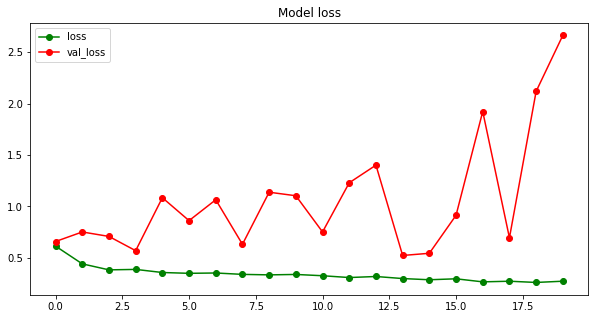

In [25]:
plt.figure(figsize = (10, 5))
plt.title("Model loss")
plt.plot(history.history["loss"], "go-")
plt.plot(history.history["val_loss"], "ro-")
plt.legend(["loss", "val_loss"])
plt.show()

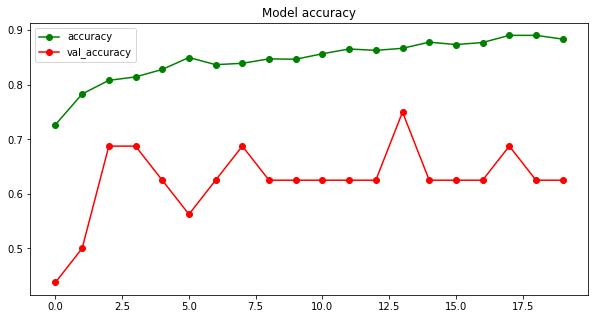

In [26]:
plt.figure(figsize = (10, 5))
plt.title("Model accuracy")

plt.plot(history.history["accuracy"], "go-")
plt.plot(history.history["val_accuracy"], "ro-")
plt.legend(["accuracy", "val_accuracy"])
plt.show()

<a id='top'></a>
<div class="list-group" id="list-tab" role="tablist">
<p style="background-color:#4A1810; font-family:sans-serif;color:#FFFFFF;font-size:130%;text-align:center;border-radius:55px 1px;">Evaluate model1 on the test set </p>

In [27]:
#scores = model1.evaluate_generator(test_set)
#print("\n%s: %.3f%%" % (model1.metrics_names[0], scores[0]*100))
#print("\n%s: %.3f%%" % (model1.metrics_names[1], scores[1]*100))

test_loss, test_accuracy = model1.evaluate(test_set, steps = 50)
print("The testing accuracy is: ", test_accuracy * 100, "%")
print("The testing loss is: ", test_loss * 100, "%")

50/50 [==============================] - 9s 179ms/step - loss: 0.9992 - accuracy: 0.7500
The testing accuracy is:  75.0 %
The testing loss is:  99.91540908813477 %


<a id='top'></a>
<div class="list-group" id="list-tab" role="tablist">
<p style="background-color:#4A1810; font-family:sans-serif;color:#FFFFFF;font-size:170%;text-align:center;border-radius:55px 1px;">TRANSFER LEARNING</p>

![](https://slideplayer.com/slide/15398015/93/images/5/Transfer+Learning.jpg)

<a id='top'></a>
<div class="list-group" id="list-tab" role="tablist">
<p style="background-color:#4A1810; font-family:sans-serif;color:#FFFFFF;font-size:130%;text-align:center;border-radius:55px 1px;">VGG16 model</p>

In [28]:
base_model1 = VGG16(include_top = False, weights = "imagenet", input_shape = (224, 224, 3), pooling = "max",
                    classes = 2)

#base_model1.load_weights("../input/vgg16/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5")
base_model1.summary()

58900480/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
______________________________________________________________

In [29]:
model2 = Sequential()
model2.add(base_model1)
model2.add(Flatten())

model2.add(Dense(128, activation = "relu"))
model2.add(Dense(64, activation = "relu"))
model2.add(Dense(32, activation = "relu"))
model2.add(Dense(1, activation = "sigmoid"))

# freeze the layers
for layer in base_model1.layers:
    layer.trainable = False

model2.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["accuracy"])

In [30]:
%%time

history = model2.fit_generator(train_set, epochs = 20, validation_data = validation_set, steps_per_epoch = 100,
                               callbacks = [early_stopping_callbacks])

Epoch 1/20
100/100 [==============================] - 38s 358ms/step - loss: 0.3986 - accuracy: 0.8087 - val_loss: 0.6726 - val_accuracy: 0.6875
Epoch 2/20
100/100 [==============================] - 35s 349ms/step - loss: 0.3136 - accuracy: 0.8550 - val_loss: 0.5572 - val_accuracy: 0.7500
Epoch 3/20
100/100 [==============================] - 35s 349ms/step - loss: 0.2985 - accuracy: 0.8650 - val_loss: 0.4124 - val_accuracy: 0.6875
Epoch 4/20
100/100 [==============================] - 35s 346ms/step - loss: 0.2642 - accuracy: 0.8856 - val_loss: 0.6417 - val_accuracy: 0.7500
Epoch 5/20
100/100 [==============================] - 35s 352ms/step - loss: 0.2808 - accuracy: 0.8775 - val_loss: 0.9485 - val_accuracy: 0.6875
Epoch 6/20
100/100 [==============================] - 36s 354ms/step - loss: 0.2444 - accuracy: 0.8881 - val_loss: 0.5148 - val_accuracy: 0.7500
Epoch 7/20
100/100 [==============================] - 35s 348ms/step - loss: 0.2381 - accuracy: 0.9056 - val_loss: 0.9191 - val_ac

### Visualize the performance of model2

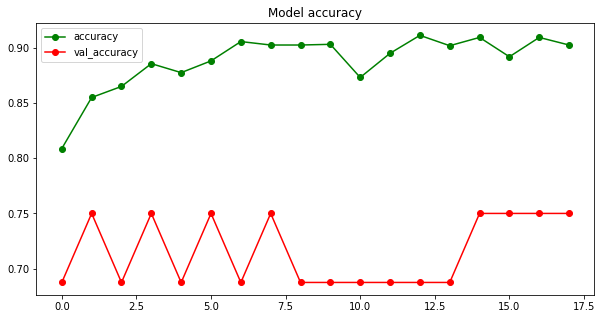

In [31]:
plt.figure(figsize = (10, 5))
plt.title("Model accuracy")
plt.plot(history.history["accuracy"], "go-")
plt.plot(history.history["val_accuracy"], "ro-")
plt.legend(["accuracy", "val_accuracy"])
plt.show()

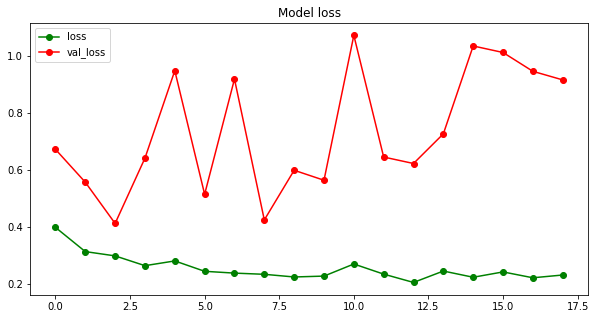

In [32]:
plt.figure(figsize = (10, 5))
plt.title("Model loss")
plt.plot(history.history["loss"], "go-")
plt.plot(history.history["val_loss"], "ro-")
plt.legend(["loss", "val_loss"])
plt.show()

### Evaluate model2 on the test set

In [33]:
#scores = model1.evaluate_generator(test_set)
#print("\n%s: %.3f%%" % (model1.metrics_names[0], scores[0]*100))
#print("\n%s: %.3f%%" % (model1.metrics_names[1], scores[1]*100))

test_loss, test_accuracy = model2.evaluate(test_set, steps = 50)
print("The testing accuracy is: ", test_accuracy * 100, "%")
print("The testing loss is: ", test_loss * 100, "%")

50/50 [==============================] - 6s 116ms/step - loss: 0.4875 - accuracy: 0.7484
The testing accuracy is:  74.83974099159241 %
The testing loss is:  48.75228703022003 %


<a id='top'></a>
<div class="list-group" id="list-tab" role="tablist">
<p style="background-color:#4A1810; font-family:sans-serif;color:#FFFFFF;font-size:130%;text-align:center;border-radius:55px 1px;">ResNet50V2 model</p>

In [34]:
base_model2 = tensorflow.keras.applications.ResNet50V2(weights = "imagenet",
                                                       input_shape = (224, 224, 3),
                                                       pooling = "max", include_top = False,
                                                       classes = 2)

for layer in base_model2.layers:
    layer.trainable = False
    
#base_model2.summary()

94683136/94668760 [==============================] - 1s 0us/step


In [35]:
model3 = Sequential()
model3.add(base_model2)
model3.add(Flatten())

model3.add(Dense(128, activation = "relu"))
model3.add(Dense(64, activation = "relu"))
model3.add(Dense(32, activation = "relu"))
model3.add(Dense(1, activation = "sigmoid"))

# freeze the layers
for layer in base_model2.layers:
    layer.trainable = False

model3.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["accuracy"])

In [36]:
%%time

history = model3.fit_generator(train_set, epochs = 20, validation_data = validation_set, steps_per_epoch = 100,
                              callbacks = [early_stopping_callbacks])

Epoch 1/20
100/100 [==============================] - 39s 358ms/step - loss: 0.4666 - accuracy: 0.8138 - val_loss: 0.5077 - val_accuracy: 0.7500
Epoch 2/20
100/100 [==============================] - 35s 351ms/step - loss: 0.2695 - accuracy: 0.8956 - val_loss: 0.4809 - val_accuracy: 0.7500
Epoch 3/20
100/100 [==============================] - 36s 356ms/step - loss: 0.2172 - accuracy: 0.9069 - val_loss: 0.3471 - val_accuracy: 0.8750
Epoch 4/20
100/100 [==============================] - 35s 346ms/step - loss: 0.2233 - accuracy: 0.9081 - val_loss: 0.2734 - val_accuracy: 0.8750
Epoch 5/20
100/100 [==============================] - 35s 349ms/step - loss: 0.2135 - accuracy: 0.9112 - val_loss: 0.2840 - val_accuracy: 0.8750
Epoch 6/20
100/100 [==============================] - 35s 351ms/step - loss: 0.1806 - accuracy: 0.9269 - val_loss: 0.3770 - val_accuracy: 0.8750
Epoch 7/20
100/100 [==============================] - 35s 347ms/step - loss: 0.1905 - accuracy: 0.9212 - val_loss: 0.2901 - val_ac

### Visualize performance of model3

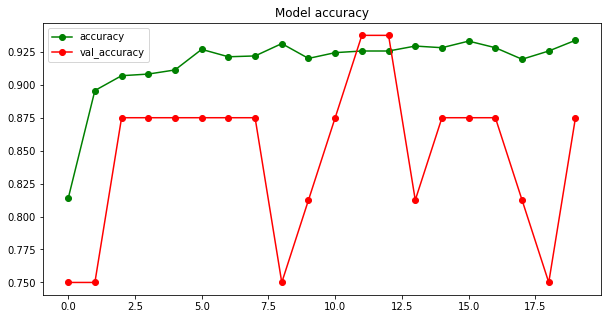

In [37]:
plt.figure(figsize = (10, 5))
plt.title("Model accuracy")
plt.plot(history.history["accuracy"], "go-")
plt.plot(history.history["val_accuracy"], "ro-")
plt.legend(["accuracy", "val_accuracy"])
plt.show()

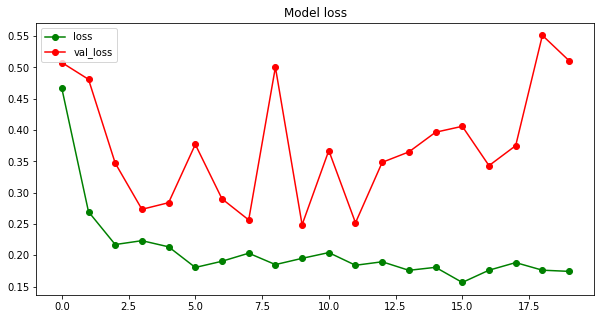

In [38]:
plt.figure(figsize = (10, 5))
plt.title("Model loss")
plt.plot(history.history["loss"], "go-")
plt.plot(history.history["val_loss"], "ro-")
plt.legend(["loss", "val_loss"])
plt.show()

### Evaluate model3 on the test set

In [39]:
#scores = model1.evaluate_generator(test_set)
#print("\n%s: %.3f%%" % (model1.metrics_names[0], scores[0]*100))
#print("\n%s: %.3f%%" % (model1.metrics_names[1], scores[1]*100))

test_loss, test_accuracy = model3.evaluate(test_set, steps = 50)
print("The testing accuracy is: ", test_accuracy * 100, "%")
print("The testing loss is: ", test_loss * 100, "%")

50/50 [==============================] - 6s 123ms/step - loss: 0.2887 - accuracy: 0.8894
The testing accuracy is:  88.94230723381042 %
The testing loss is:  28.872865438461304 %


<a id='top'></a>
<div class="list-group" id="list-tab" role="tablist">
<p style="background-color:#4A1810; font-family:sans-serif;color:#FFFFFF;font-size:130%;text-align:center;border-radius:55px 1px;">Prediction of a new image </p>

In [40]:
%%time

new_image_path = "/kaggle/input/pneumonia-lungs/download.jpg"
test_image = image.load_img(new_image_path, target_size = (224, 224))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
#test_image = np.reshape(test_image, (1, 224, 224, 3))
test_image = test_image / 255

#___________________________________________________________________

result = model3.predict(test_image)
train_set.class_indices
if result[0][0] == 0:
    prediction = "N O R M A L"
else:
    prediction = "P N E U M O N I A"

print(prediction)

P N E U M O N I A
CPU times: user 900 ms, sys: 7.97 ms, total: 908 ms
Wall time: 942 ms


### Save the model to disk

In [41]:
model3.save("my_pneumonia_detection_model.h5")
print(colored("Model3 was succesfully saved to disk...", color = "green", attrs = ["bold", "dark"]))

Model3 was succesfully saved to disk...


### Some time later you may need that model to use

In [42]:
model_loaded = tensorflow.keras.models.load_model("/kaggle/working/my_pneumonia_detection_model.h5")
model_loaded.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Functional)      (None, 2048)              23564800  
_________________________________________________________________
flatten_2 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)               262272    
_________________________________________________________________
dense_9 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_10 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 33        
Total params: 23,837,441
Trainable params: 272,641
Non-trainable params: 23,564,800
____________________________________

### Use loaded model to predict new image

This image is 100.000 percent P N E U M O N I A


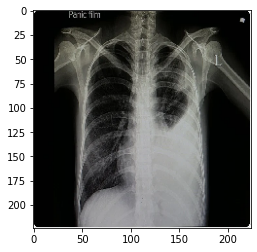

In [43]:
def image_prediction(new_image_path):
    test_image = image.load_img(new_image_path, target_size = (224, 224))
    test_image = image.img_to_array(test_image)
    #test_image = np.reshape(test_image, (224, 224, 3))
    test_image = np.expand_dims(test_image, axis = 0)
    test_image = test_image / 255.0
    model_loaded = tensorflow.keras.models.load_model("/kaggle/working/my_pneumonia_detection_model.h5")
    prediction = model_loaded.predict(test_image)
    test_image_for_plotting = image.load_img(new_image_path, target_size = (224, 224))
    plt.imshow(test_image_for_plotting)
    if(prediction[0] > 0.5):
        statistic = prediction[0] * 100 
        print("This image is %.3f percent %s"% (statistic, "P N E U M O N I A"))
    else:
        statistic = (1.0 - prediction[0]) * 100
        print("This image is %.3f percent %s" % (statistic, "N O R M A L"))
     
 
# call and use the function
image_prediction("/kaggle/input/pneumonia-lung-image-for-test/image.webp")

### Get test data and test labels

In [44]:
test_dir = "../input/chest-xray-pneumonia/chest_xray/test"
test_data, test_labels = [], []

In [45]:
for i in ["/NORMAL/", "/PNEUMONIA/"]:
    for image in (os.listdir(test_dir + i)):
        image = plt.imread(test_dir + i + image)
        image = cv2.resize(image, (224, 224))
        image = np.dstack([image, image, image])
        image = image.astype("float32") / 255
        if i == "/NORMAL/":
            label = 0
        elif i == "/PNEUMONIA/":
            label = 1
        test_data.append(image)
        test_labels.append(label)

test_data = np.array(test_data)
test_labels = np.array(test_labels)

### Plot confusion matrix

_______C o n f u s i o n   m a t r i x_______



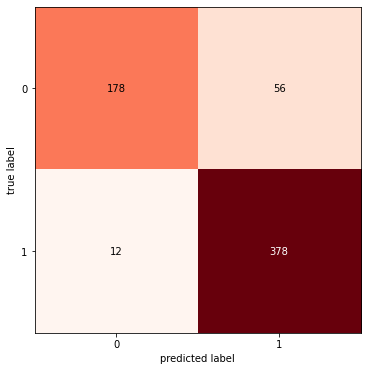

In [46]:
print("_______C o n f u s i o n   m a t r i x_______\n")

predictions = model_loaded.predict(test_data)
conf_m = confusion_matrix(test_labels, np.round(predictions))
acc = accuracy_score(test_labels, np.round(predictions)) * 100
tn, fp, fn, tp = conf_m.ravel()

fig, ax = plot_confusion_matrix(conf_mat = conf_m, figsize = (6, 6), cmap = matplotlib.pyplot.cm.Reds)
plt.show()

### Get test metrics

In [47]:
%%time

precision = tp / (tp + fp) * 100
recall = tp / (tp + fn) * 100
print("Accuracy: {}%".format(acc))
print("Precision: {}%".format(precision))
print("Recall: {}%".format(recall))
print("F1-score: {}".format(2 * precision * recall / (precision + recall)))   

Accuracy: 89.1025641025641%
Precision: 87.09677419354838%
Recall: 96.92307692307692%
F1-score: 91.74757281553397
CPU times: user 0 ns, sys: 180 µs, total: 180 µs
Wall time: 173 µs


## Let's display correct and incorrect predicted classes

In [48]:
predictions = list()
preds = model_loaded.predict(test_data)
for i in preds:
    if i >= 0.5:
        predictions.append(1)
    else:
        predictions.append(0)
predictions[:15]

[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]

<mark>np.nonzero() function is used to compute the indices of the elements that are non-zero. <\mark> 

In [49]:
correct_predictions = np.nonzero(predictions == test_labels)[0]
incorrect_predictions = np.nonzero(predictions != test_labels)[0]

# let's look at indices of correct predictions
print("Indices of correct predictions:\n", correct_predictions[:15])

# let's look at indices of incorrect correct predictions
print("\nIndices of incorrect predictions:\n", incorrect_predictions[:15])

Indices of correct predictions:
 [ 0  1  2  4  5  6  7  8  9 10 11 13 14 15 17]

Indices of incorrect predictions:
 [ 3 12 16 18 19 21 23 24 26 31 33 35 40 47 52]


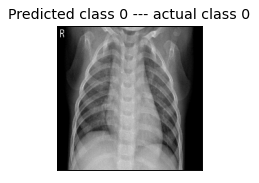

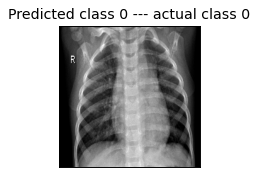

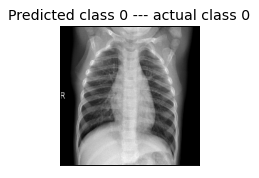

In [50]:
# display correct predictions

i = 0
for a in correct_predictions[:3]:
    plt.figure(figsize = (8, 6), dpi = 85)
    plt.subplot(3, 1, i + 1)
    plt.xticks([]), plt.yticks([])
    plt.imshow(test_data[a].reshape(224, 224, 3))
    plt.title("Predicted class {} --- actual class {}".format(predictions[a], test_labels[a]))
    plt.tight_layout()
    i += 1

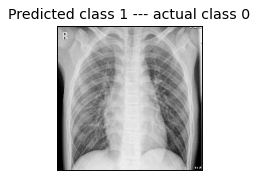

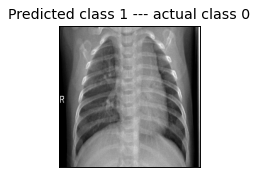

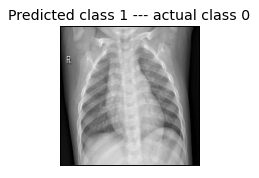

In [51]:
# display incorrect predictions

i = 0
for a in incorrect_predictions[:3]:
    plt.figure(figsize = (8, 6), dpi = 85)
    plt.subplot(3, 1, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(test_data[a].reshape(224, 224, 3))
    plt.title("Predicted class {} --- actual class {}".format(predictions[a], test_labels[a]))
    plt.tight_layout()
    i += 1

# Reference for pictures and animations



https://medium.datadriveninvestor.com/convolutional-neural-networks-3b241a5da51e

https://www.computer.org/csdl/journal/si/2020/04/08957307/1ilQS7GE9MY

https://towardsdatascience.com/what-is-transposed-convolutional-layer-40e5e6e31c11

https://nico-curti.github.io/NumPyNet/NumPyNet/layers/maxpool_layer.html

https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53


# Thank you all for reading my notebook! 🤗